# Soil Organic Carbon Data Exploration and DPPD

[Factors that effects SOC](doi.org/10.3390/ijerph17165697) are soil bulk density, elevation, vegetation, clay content, land cover type etc. 
To do data exploration for SOC, following libraries has been imported.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import pandas as pd
import rasterio
from rasterstats import zonal_stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from osgeo import gdal


In [2]:
data = gpd.read_file('../../../../src/data_preprocessing/base_geojson/Telangana_grid1km.geojson')

To do mandal wise analysis, a funtion has been created to get mean values of within the mandal boundary

In [55]:
def meanvalues(tif, adm_bound, data):
    mean_list = []
    if adm_bound == 'mandal':

        for j in range(len(data)):                #iterating all rows of dataframe to get point info

            stats = zonal_stats(data.iloc[j].geometry, tif, stats="*", categorical=True)         #getting statistics from the raster point 
            i = stats[0]                                                                          #storing statsistical dictionary in a value
            mean = i['mean']
            mean_list.append(mean)
    elif adm_bound == 'dist':
        data = gpd.read_file('../../../../src/data_preprocessing/base_geojson/TS_district_boundary.json')  #Mandal (an administrative boundary) Shapefile
        data = data.sort_values(by=['Dist_Name'])
        data = data.reset_index()
        mean_list = []
        for j in range(len(data)):                #iterating all rows of dataframe to get point info

            stats = zonal_stats(data.iloc[j].geometry, tif, stats="*", categorical=True)         #getting statistics from the raster point 
            i = stats[0]                                                                          #storing statsistical dictionary in a value
            mean = i['mean']
            mean_list.append(mean)
    else:
        print('Wrong boundary name')
    return mean_list

DEM file has been created using SRTM DEM and reprojected to 250m<br>
NDVI created using annual composite of MODIS 16 Days data<br>
Soil Organic Carbon has been created using [SoilGrids](soilgrids.org)<br>
Soil Bulk density has ben created using [SoilGrids](soilgrids.org)<br>
Soil clay content has ben created using [SoilGrids](soilgrids.org)<br>
Telangana state boundary is available on both Telangana Govt. Website and DiCRA github repo<br>
<br>
All datasets has been read and taken mandal wise mean value of those

In [56]:
data = gpd.read_file('../../../../src/data_preprocessing/base_geojson/TS_mandal_boundary.json')  #Mandal (an administrative boundary) Shapefile
data = data.sort_values(by=['Mandal_Nam'])
data = data.reset_index()
del data['index']
adm = 'mandal'
soc_mandal = gpd.GeoDataFrame()
#soc_mandal['index'] = data.index
soc_mandal['Mandal_Nam'] = data.Mandal_Nam
soc_mandal['Dist_Name'] = data.Dist_Name

mean_list = meanvalues('SoilOrganicCarbon/SOC_2020_0-5cm.tif',adm, data)
soc_mandal['soc'] = mean_list
mean_list = meanvalues('SoilOrganicCarbon/NDVI.tif',adm, data)
soc_mandal['ndvi'] = mean_list
mean_list = meanvalues('SoilOrganicCarbon/SoilBulkDensity_0-5cm.tif',adm, data)
soc_mandal['bulkdensity'] = mean_list
mean_list = meanvalues('SoilOrganicCarbon/ClayContent_0-5cm.tif',adm, data)
soc_mandal['clay'] = mean_list
mean_list = meanvalues('SoilOrganicCarbon/DEM.tif',adm, data)
soc_mandal['dem'] = mean_list

soc_mandal['geometry'] = data.geometry

In [57]:
soc_mandal

,Mandal_Nam,Dist_Name,soc,ndvi,bulkdensity,clay,dem,geometry
0,Abdullapurmet,Rangareddy,155.149729,4103.407403,148.092338,318.105066,487.613306,"POLYGON ((78.58558 17.34675, 78.60189 17.34188..."
1,Achampet,Nagarkurnool,257.156051,3976.123783,142.727434,303.693157,432.241039,"POLYGON ((79.06269 16.44607, 79.04739 16.45883..."
2,Adavidevulapally,Nalgonda,286.929680,4147.680578,134.277950,271.951346,99.825521,"POLYGON ((79.52430 16.72522, 79.48673 16.71371..."
3,Addagudur,Yadadri Bhuvanagiri,230.413881,4337.839397,143.245098,321.254902,240.411961,"POLYGON ((79.36517 17.48429, 79.34519 17.46905..."
4,Addakal,Mahabubnagar,254.478733,4104.739292,150.591563,313.275168,375.385540,"POLYGON ((78.00552 16.56734, 78.00110 16.57589..."
...,...,...,...,...,...,...,...,...
587,Yellareddypet,Rajanna Sircilla,161.710543,4880.430970,152.636671,374.577131,410.192992,"POLYGON ((78.74235 18.41570, 78.72122 18.42223..."
588,Yergatla,Nizamabad,140.636126,4967.252294,147.253924,375.142198,304.432347,"POLYGON ((78.50814 18.97132, 78.49690 18.97313..."
589,Yerrupalem,Khammam,293.420664,5584.949051,136.202991,254.697720,101.692327,"POLYGON ((80.47000 16.94077, 80.46556 16.92792..."
590,Zaffergadh,Jangoan,177.900802,4879.305105,144.190807,322.392043,301.089543,"POLYGON ((79.51447 17.79391, 79.51459 17.81810..."


Soil Organic Carbon and Soil Bulk Density relation

<AxesSubplot:xlabel='soc', ylabel='bulkdensity'>

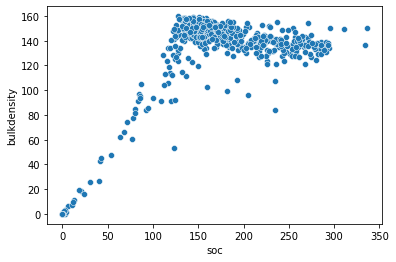

In [58]:
sns.scatterplot(x="soc", y="bulkdensity", data=soc_mandal)

Soil Organic Carbon and NDVI relation

<AxesSubplot:xlabel='soc', ylabel='ndvi'>

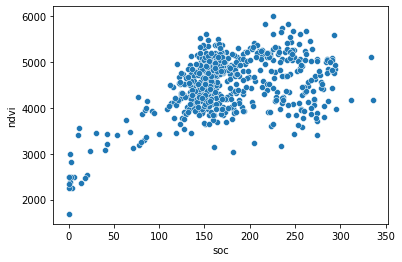

In [59]:
sns.scatterplot(x="soc", y="ndvi", data=soc_mandal)

Soil Organic Carbon and Clay Content relation

<AxesSubplot:xlabel='soc', ylabel='clay'>

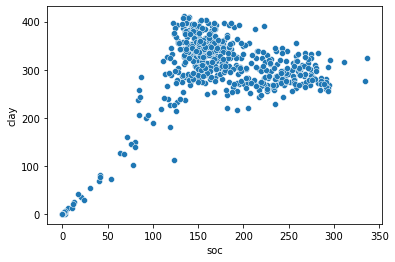

In [60]:
sns.scatterplot(x="soc", y="clay", data=soc_mandal)

Soil Organic Carbon and Elevation relation

<AxesSubplot:xlabel='soc', ylabel='dem'>

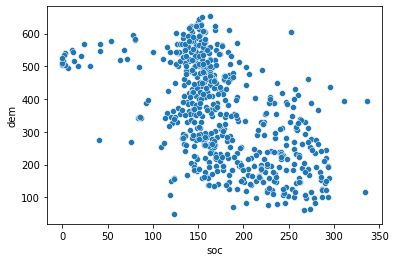

In [61]:
sns.scatterplot(x="soc", y="dem", data=soc_mandal)  

mandal wise averaged maps fr different dataset

<AxesSubplot:>

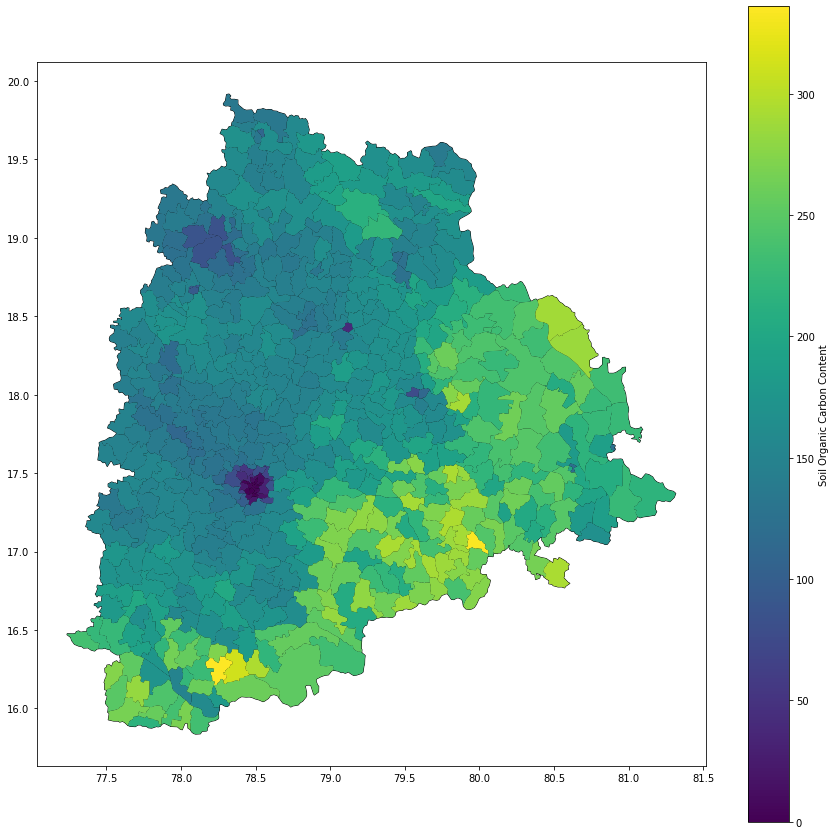

In [62]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='soc', ax=base, legend=True, legend_kwds={'label': "Soil Organic Carbon Content"}, figsize=(8,8))

<AxesSubplot:>

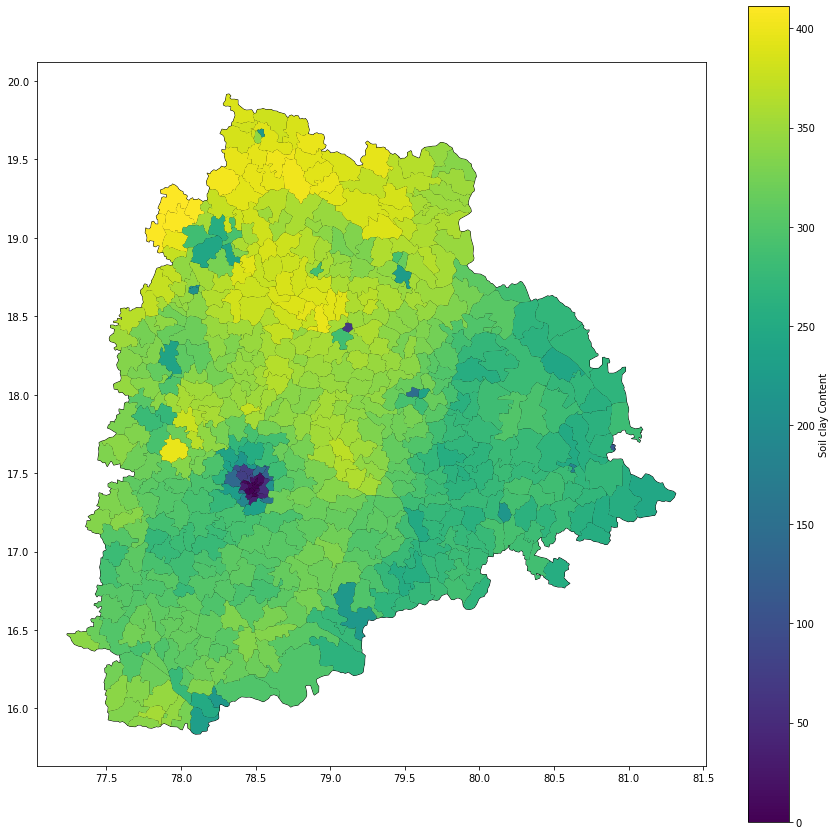

In [63]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='clay', ax=base, legend=True, legend_kwds={'label': "Soil clay Content"}, figsize=(8,8))

<AxesSubplot:>

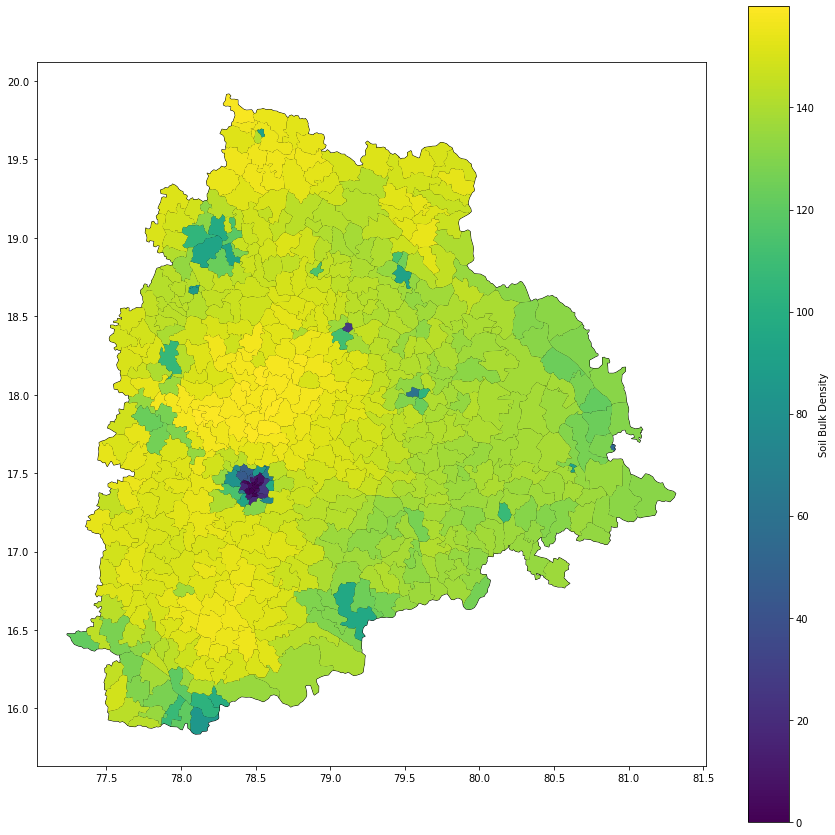

In [64]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='bulkdensity', ax=base, legend=True, legend_kwds={'label': "Soil Bulk Density"}, figsize=(8,8))

<AxesSubplot:>

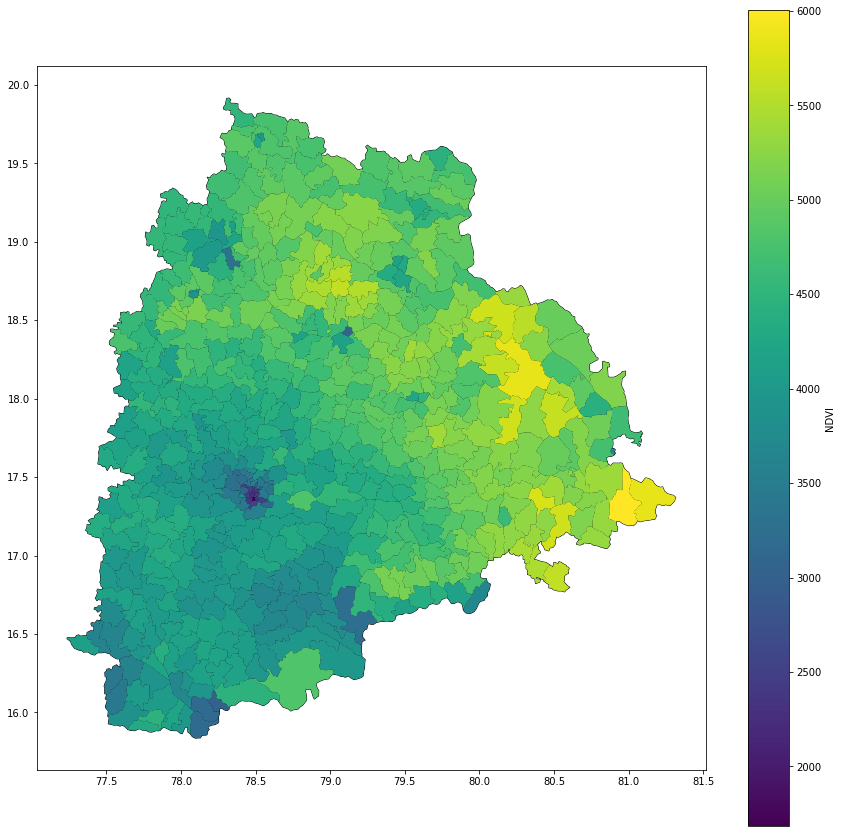

In [65]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='ndvi', ax=base, legend=True, legend_kwds={'label': "NDVI"}, figsize=(8,8))

<AxesSubplot:>

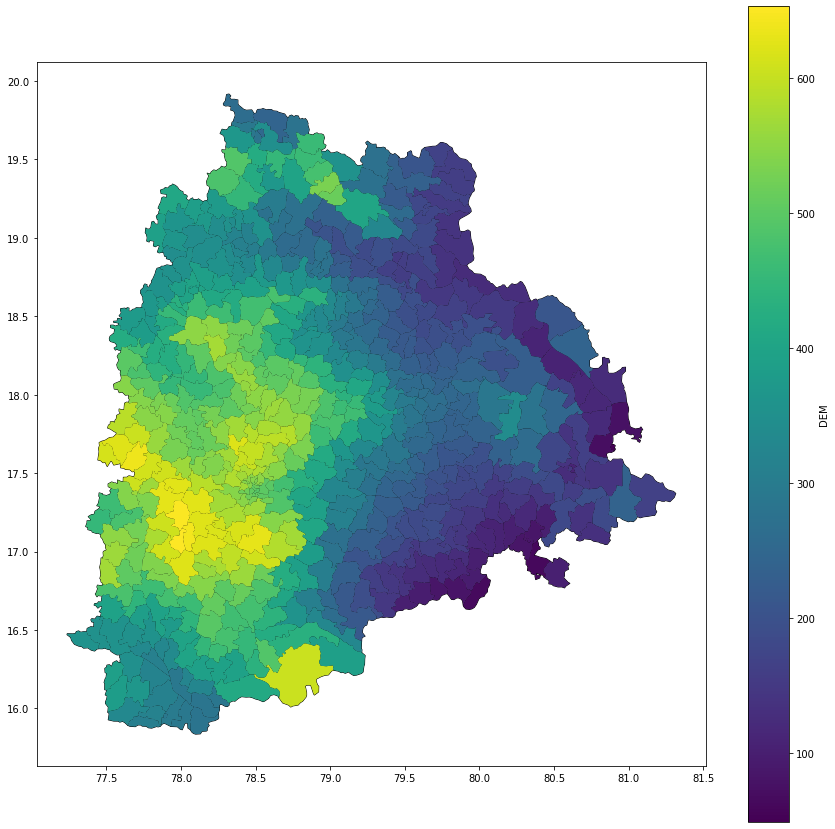

In [66]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='dem', ax=base, legend=True, legend_kwds={'label': "DEM"}, figsize=(8,8))

From the dataframe which contains all averaged values of the different datasets, the input dataset has been taken as X and SOC took as y. A linear regression model has been built for a relationship between input and output values.<br>
<br>
Predicted values have been matched with true values and normalized to get values between a range of -1 and 1. So -1 shows the maximum SOC negative difference and 1 shows the maximum SOC negative difference. Which can be stated as deviances in SOC in similar conditions of input variables

In [67]:
import numpy as np

X = soc_mandal.values[:,3:7]
y =soc_mandal.soc

reg = LinearRegression().fit(X, y)
y_pred_trend = reg.predict(X)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('Regression Score: ',reg.score(X, y))
print('Mean Absolute Error: ',mean_absolute_error(y, y_pred_trend))
print('Root Mean Squared Error: ',mean_squared_error(y, y_pred_trend, squared=False))

Regression Score:  0.5937302080614998
Mean Absolute Error:  27.8973438086942
Root Mean Squared Error:  37.1012775518828


<AxesSubplot:>

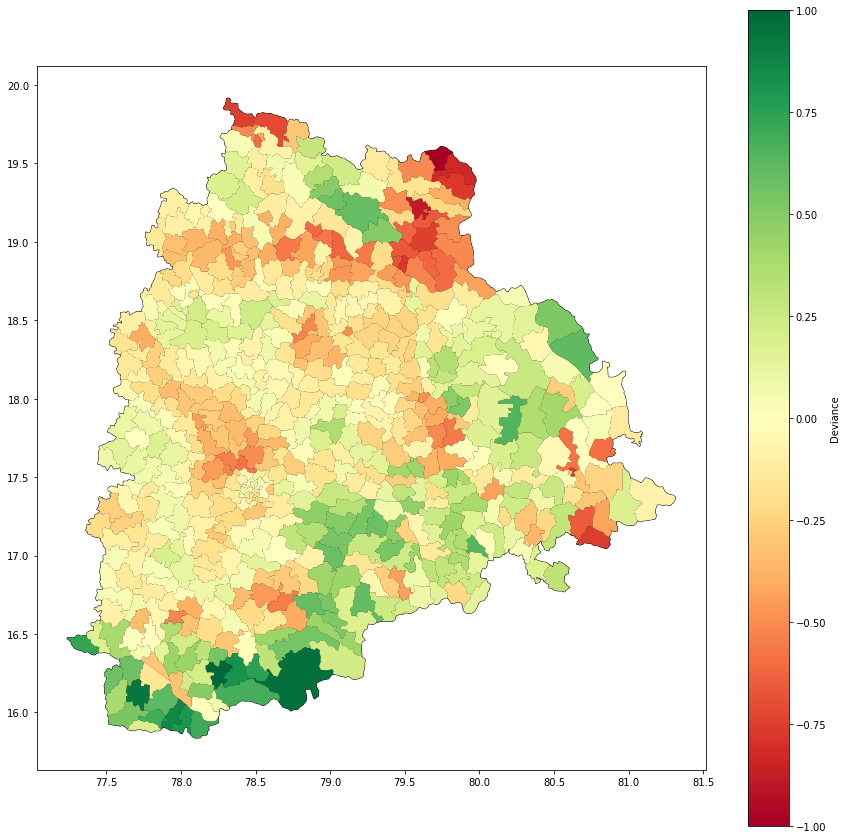

In [79]:
res = np.subtract(y,y_pred_trend)
#norm = (res - res.min())/ (res.max() - res.min())
data_norm = np.where(res >= 0, res/np.max(res), -res/np.min(res))
#data_norm1 = (norm - 0.5)/ 0.5
soc_mandal['y_pred'] = list(y_pred_trend)
soc_mandal['deviance'] = list(data_norm)

base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='deviance', ax=base, cmap='RdYlGn', legend=True, legend_kwds={'label': "Deviance"}, figsize=(8,8))

Create json file for visualization in dicra:

In [77]:
mandal_json = 'https://raw.githubusercontent.com/undpindia/dicra/main/src/data_preprocessing/base_geojson/TS_mandal_boundary.json'

mandal_shp = gpd.read_file(mandal_json)
mandal_shp = mandal_shp.sort_values(by=['Mandal_Nam'])
mandal_shp['deviance'] = list(soc_mandal.deviance)
mandal_shp.to_file("SoilOrganicCarbon/soc_deviance_mandal.json")

mandal_shp = gpd.read_file(mandal_json)
mandal_shp = mandal_shp.sort_values(by=['Mandal_Nam'])
mandal_shp['soc'] = list(soc_mandal.soc)
mandal_shp.to_file("SoilOrganicCarbon/soc_mandal.json")

mandal_shp = gpd.read_file(mandal_json)
mandal_shp = mandal_shp.sort_values(by=['Mandal_Nam'])
mandal_shp['soc'] = list(soc_mandal.bulkdensity)
mandal_shp.to_file("SoilOrganicCarbon/bulkdensity_mandal.json")

mandal_shp = gpd.read_file(mandal_json)
mandal_shp = mandal_shp.sort_values(by=['Mandal_Nam'])
mandal_shp['soc'] = list(soc_mandal.clay)
mandal_shp.to_file("SoilOrganicCarbon/clay_content_mandal.json")

In [6]:
def meavaluesgrid(tif, data):
    mean_list = []
    for j in range(len(data)):                #iterating all rows of dataframe to get point info
        stats = zonal_stats(data.iloc[j].geometry, tif, stats="*", categorical=True)         #getting statistics from the raster point 
        i = stats[0]                                                                          #storing statsistical dictionary in a value
        mean = i['mean']
        mean_list.append(mean)
    return(mean_list)

In [4]:
data1 = gpd.read_file('../../../../src/data_preprocessing/base_geojson/Telangana_grid1km.geojson')  #Mandal (an administrative boundary) Shapefile

In [7]:
data = data1.reset_index()
#data = data.head(100)
soc_mandal = gpd.GeoDataFrame()
mean_list = meavaluesgrid('SoilOrganicCarbon/SOC_2020_0-5cm.tif', data)
soc_mandal['soc'] = mean_list
mean_list = meavaluesgrid('SoilOrganicCarbon/NDVI.tif',data)
soc_mandal['ndvi'] = mean_list
mean_list = meavaluesgrid('SoilOrganicCarbon/SoilBulkDensity_0-5cm.tif', data)
soc_mandal['bulkdensity'] = mean_list
mean_list = meavaluesgrid('SoilOrganicCarbon/ClayContent_0-5cm.tif', data)
soc_mandal['clay'] = mean_list
mean_list = meavaluesgrid('SoilOrganicCarbon/DEM.tif', data)
soc_mandal['dem'] = mean_list

soc_mandal['geometry'] = data.geometry

In [8]:
soc_mandal.to_file('soc_deviance1km.geojson')

In [3]:
len(data)

113429

In [4]:
soc_mandal = gpd.read_file('soc_deviance1km.geojson')

In [36]:
soc_mandal = soc_mandal.dropna()

In [37]:
import numpy as np

X = soc_mandal.values[:,1:5]
y =soc_mandal.soc

reg = LinearRegression().fit(X, y)
y_pred_trend = reg.predict(X)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('Regression Score: ',reg.score(X, y))
print('Mean Absolute Error: ',mean_absolute_error(y, y_pred_trend))
print('Root Mean Squared Error: ',mean_squared_error(y, y_pred_trend, squared=False))

Regression Score:  0.1291240763808187
Mean Absolute Error:  50.81489756204942
Root Mean Squared Error:  66.8114617178593


In [38]:
res = np.subtract(y,y_pred_trend)
#norm = (res - res.min())/ (res.max() - res.min())
data_norm = np.where(res >= 0, res/np.max(res), -res/np.min(res))
#data_norm1 = (norm - 0.5)/ 0.5
soc_mandal['y_pred'] = list(y_pred_trend)
soc_mandal['deviance'] = list(data_norm)

#base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
#soc_mandal.plot(column='deviance', ax=base, cmap='RdYlGn', legend=True, legend_kwds={'label': "Deviance"}, figsize=(8,8))

In [100]:
soc_mandal = gpd.read_file('soc_deviance1km.geojson')
soc_mandal = soc_mandal.to_crs(32644)

In [104]:
len(soc_mandal['geometry'].centroid.x.unique())

14758